In [108]:
import pandas as pd
import scipy.io
import numpy as np
from pyvis.network import Network
import matplotlib.pyplot as plt
import collections
import json
import matlab.engine
from sklearn.linear_model import LinearRegression

In [109]:
bus = scipy.io.loadmat('MATPOWER/bus.mat')['bus']
power_demand = bus[:, 2]
df = pd.read_csv("GIS/CATS_gens.csv")
df = df[df['Pmax'] != 0.0].to_numpy()
#df = df.drop_duplicates(subset=['PlantCode','GenID']).to_numpy()
indices = []
for i, r in enumerate(df):
    if r[3] == "Solar Photovoltaic" or r[3] == "Solar Thermal without Energy Storage" or r[3] == "Onshore Wind Turbine" or r[3] == "Hydroelectric Pumped Storage" or r[3] == "Conventional Hydroelectric" or r[3] == "IMPORT":
        indices.append(i+1)
bus_loc = pd.read_csv("GIS/CATS_buses.csv").to_numpy()[:, [4,5]]
gen_loc = df[:, -2:]
indx = {"idx": indices}
scipy.io.savemat("indices.mat", indx)

In [110]:
gen_by_fuel = collections.defaultdict(float)
for row in df:
    gen_by_fuel[row[3]] += row[5]
gen_by_fuel

defaultdict(float,
            {'Conventional Hydroelectric': 7922.999999999999,
             'Petroleum Liquids': 369.09999999999997,
             'Natural Gas Fired Combustion Turbine': 10893.39999999999,
             'Natural Gas Internal Combustion Engine': 325.5999999999998,
             'Natural Gas Fired Combined Cycle': 19649.300000000007,
             'Natural Gas Steam Turbine': 4744.799999999999,
             'Landfill Gas': 278.6,
             'Batteries': 229.50000000000003,
             'Hydroelectric Pumped Storage': 759.1,
             'Geothermal': 1095.2,
             'Nuclear': 2323.0,
             'Onshore Wind Turbine': 5303.000000000001,
             'Other Waste Biomass': 168.5999999999999,
             'Wood/Wood Waste Biomass': 504.8,
             'Solar Photovoltaic': 11639.398672710053,
             'Solar Thermal without Energy Storage': 1156.00132935,
             'All Other': 113.69999999999999,
             'Conventional Steam Coal': 55.0,
             'O

([<matplotlib.patches.Wedge at 0x2416a74c890>,
 [Text(0.039724065912204544, 1.099282492622985, 'Natural Gas'),
  Text(-0.9771535493097955, -0.5051444754436787, 'Solar'),
  Text(-0.47308648938908066, -0.9930705783364622, 'Nuclear'),
  Text(-0.3694088411992272, -1.0361163583516304, 'Coal'),
  Text(0.03589592056352277, -1.0994141543962845, 'Hydro'),
  Text(0.46389069160762325, -0.9973993313812684, 'Biomass'),
  Text(0.5245050961498903, -0.9668993764155578, 'Other'),
  Text(0.5989679525457631, -0.9226252716152624, 'Geothermal'),
  Text(0.8267816161462146, -0.7255564479781388, 'Wind'),
  Text(1.060340272534955, -0.2927089107637443, 'Import'),
  Text(1.099707973500614, -0.025345078795947298, 'Biogas')],
 [Text(0.02166767231574793, 0.5996086323398099, '48.9%'),
  Text(-0.5329928450780702, -0.27553335024200654, '17.5%'),
  Text(-0.2580471760304076, -0.5416748609107975, '3.2%'),
  Text(-0.2014957315632148, -0.5651543772827075, '0.1%'),
  Text(0.01957959303464878, -0.5996804478525188, '11.9%'),


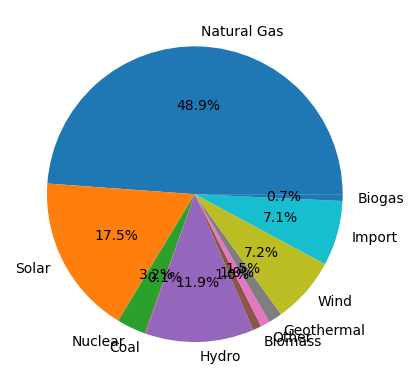

In [111]:
y = [0]*11
for k, v in gen_by_fuel.items():
    if 'Natural Gas' in k:
        y[0] += v
    elif 'Solar' in k:
        y[1] += v
    elif 'Nuclear' in k:
        y[2] += v
    elif 'Coal' in k:
        y[3] += v
    elif 'Hydro' in k:
        y[4] += v
    elif 'Biomass' in k or 'Waste' in k:
        y[5] += v
    elif 'Geothermal' in k:
        y[7] += v
    elif 'Wind' in k:
        y[8] += v
    elif 'IMPORT' in k:
        y[9] += v
    elif 'Landfill' in k or 'Other Gases' in k:
        y[10] += v
    else:
        y[6] += v
x = ['Natural Gas', 'Solar','Nuclear','Coal','Hydro','Biomass','Other','Geothermal','Wind','Import','Biogas']
fig, ax = plt.subplots()
ax.pie(y, labels=x,autopct='%1.1f%%')

In [112]:
# https://www.eia.gov/electricity/data/emissions/
gen_emission = pd.read_excel("data/emissions2019.xlsx")
gen_emission = gen_emission[gen_emission['Generation (kWh)'] > 0]
gen_emission = gen_emission[gen_emission['State'] == 'CA']
gen_emission = gen_emission[['Plant Code','Fuel Code','Aggregated Fuel Group','Generation (kWh)','Metric Tonnes of CO2 Emissions','carbon emission rate']]
d1 = gen_emission.groupby(['Aggregated Fuel Group'])['Generation (kWh)'].sum()
d2 = gen_emission.groupby(['Aggregated Fuel Group'])['Metric Tonnes of CO2 Emissions'].sum()
d2*1000/d1
# get carbon emssion rate of each fuel type (tons/mWh)

Aggregated Fuel Group
COAL    4.692794
GAS     0.455939
GEO     0.026307
MSW     0.834946
PET     0.878813
dtype: float64

In [113]:
gen_emission.groupby(['Fuel Code'])['carbon emission rate'].median()

Fuel Code
BIT    4.642909
DFO    1.191675
GEO    0.026307
JF     1.180994
MSW    0.834394
NG     0.585267
PG     1.083609
RC     4.693628
WO     0.534195
Name: carbon emission rate, dtype: float64

In [114]:
type_to_emission = collections.defaultdict(float)
type_to_emission['Conventional Hydroelectric'] = 0.0001
type_to_emission['Hydroelectric Pumped Storage'] = 0.0001
type_to_emission['Petroleum Liquids'] = 1.114133
type_to_emission['Natural Gas Internal Combustion Engine'] = 0.455939
type_to_emission['Natural Gas Fired Combined Cycle'] = 0.455939
type_to_emission['Natural Gas Steam Turbine'] = 0.455939
type_to_emission['Natural Gas Fired Combustion Turbine'] = 0.455939
type_to_emission['Nuclear'] = 0.000001
type_to_emission['Geothermal'] = 0.026307
type_to_emission['Onshore Wind Turbine'] = 0.0001
type_to_emission['Other Waste Biomass'] = 0.02970
type_to_emission['Wood/Wood Waste Biomass'] = 0.02970
type_to_emission['Landfill Gas'] = 0.646560
type_to_emission['Solar Photovoltaic'] = 0.0001
type_to_emission['Solar Thermal without Energy Storage'] = 0.0001
type_to_emission['Conventional Steam Coal'] = 0.531497
type_to_emission['Other Gases'] = 0.455939
type_to_emission['Batteries'] = 0.0001
type_to_emission['Petroleum Coke'] = 1.114133
type_to_emission['Municipal Solid Waste'] = 0.834946
type_to_emission['Other Natural Gas'] = 0.455939
type_to_emission['All Other'] = 0.104261
type_to_emission['IMPORT'] = 0.104261
#type_to_emission['Synchronous Condenser'] = 884

In [115]:
# https://www.epa.gov/egrid
emission_power_plant = pd.read_excel("data/emission_egrid.xlsx")
emission_power_plant = emission_power_plant[emission_power_plant['Plant annual net generation'] > 0]
emission_power_plant = emission_power_plant[emission_power_plant['Plant state abbreviation'] == 'CA']
emission_power_plant["plant_emission_rate"] = emission_power_plant["Plant annual CO2 emissions"]/emission_power_plant["Plant annual net generation"]

In [116]:
emission_power_plant.groupby(['Plant primary coal/oil/gas/ other fossil fuel category'])['plant_emission_rate'].mean()

Plant primary coal/oil/gas/ other fossil fuel category
BIOMASS       0.031964
COAL          0.574314
GAS           0.392918
GEOTHERMAL    0.064474
HYDRO         0.000000
NUCLEAR       0.000000
OFSL          0.420986
OIL           1.114133
OTHF          0.302718
SOLAR         0.000501
WIND          0.000000
Name: plant_emission_rate, dtype: float64

In [117]:
# egrid_2019
# https://www.epa.gov/egrid
# we have percent mixure of power generation by fuel types. We have carbon emission rate of each generator. We can get the carbon emission rate of the each fuel type.
emission_power_plant = pd.read_excel("data/Book1.xlsx")
pd.set_option('display.max_columns', None)
emission_power_plant = emission_power_plant[emission_power_plant['Plant annual net generation (MWh)'] > 0]
emission_power_plant = emission_power_plant[emission_power_plant['Plant state abbreviation'] == 'CA']
emission_power_plant['Plant annual CO2 equivalent total output emission rate (metric tons/MWh)'] = emission_power_plant['Plant annual CO2 equivalent total output emission rate (lb/MWh)']/2204.62
emission_power_plant.head(5)

,Plant state abbreviation,DOE/EIA ORIS plant or facility code,Utility ID,Plant FIPS county code,Plant latitude,Plant longitude,Plant primary fuel,Plant primary coal/oil/gas/ other fossil fuel category,Plant annual net generation (MWh),Plant annual CO2 equivalent emissions (tons),Plant annual CO2 equivalent total output emission rate (lb/MWh),Plant coal generation percent (resource mix),Plant oil generation percent (resource mix),Plant gas generation percent (resource mix),Plant nuclear generation percent (resource mix),Plant hydro generation percent (resource mix),Plant biomass generation percent (resource mix),Plant wind generation percent (resource mix),Plant solar generation percent (resource mix),Plant geothermal generation percent (resource mix),Plant other fossil generation percent (resource mix),Plant other unknown / purchased fuel generation percent (resource mix),Plant annual CO2 equivalent total output emission rate (metric tons/MWh)
474,CA,57310,57320,37.0,33.794283,-118.241405,SUN,SOLAR,1781.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
475,CA,58918,61315,19.0,36.670000,-119.415833,SUN,SOLAR,1535.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
476,CA,58920,61315,47.0,37.352222,-120.506944,SUN,SOLAR,2656.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
477,CA,58919,61315,7.0,39.291667,-121.669722,SUN,SOLAR,2410.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
478,CA,57871,11208,37.0,34.026944,-118.224167,SUN,SOLAR,1252.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [118]:
# Use least square. Percent fuel type of each gen * carbon emission of each fuel type = carbon emission of each gen
A = emission_power_plant.to_numpy()[:, 11:-1]
b = emission_power_plant.to_numpy()[:, -1]
x, resi, r, s = np.linalg.lstsq(A.astype('float'), b.astype('float')) # x is carbon emission of each fuel type
dict_carb = collections.defaultdict(float)
dict_carb["Coal"] = x[0]
dict_carb["Oil"] = x[1]
dict_carb["Gas"] = x[2]
dict_carb["Nuclear"] = x[3]
dict_carb["Hydro"] = x[4]
dict_carb["Biomass"] = x[5]
dict_carb["Wind"] = x[6]
dict_carb["Solar"] = x[7]
dict_carb["Geothermal"] = x[8]
dict_carb["Other fossil"] = x[9]
dict_carb["Other/Import"] = x[10]

C:\Users\syq41\AppData\Local\Temp\ipykernel_62672\2484647333.py:4: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  x, resi, r, s = np.linalg.lstsq(A.astype('float'), b.astype('float')) # x is carbon emission of each fuel type


In [119]:
dict_carb

defaultdict(float,
            {'Coal': 0.5314975802795217,
             'Oil': 1.3178187916140418,
             'Gas': 0.3582052877233134,
             'Nuclear': 4.440892098500626e-16,
             'Hydro': 1.1102230246251565e-16,
             'Biomass': 0.029702157130995444,
             'Wind': 4.556679422329091e-18,
             'Solar': 0.00040708553821955373,
             'Geothermal': 0.0584896013043455,
             'Other fossil': 0.6539273187952721,
             'Other/Import': 0.10426143309084011})

In [14]:
# emission rate of gen based on clostest distance in real gen data
'''emission_power_plant = emission_power_plant.to_numpy()[:, [3,4,9]]
carbon_emission = [0]*2149
for i, v in enumerate(gen_loc):
    coords_1 = (v[0], v[1])
    min_dist = math.inf
    for x2, y2, e2 in emission_power_plant:
        coords_2 = (x2, y2)
        distance = geopy.distance.geodesic(coords_1, coords_2).km
        if distance < min_dist:
            carbon_emission[i] = e2
            min_dist = distance'''

'emission_power_plant = emission_power_plant.to_numpy()[:, [3,4,9]]\ncarbon_emission = [0]*2149\nfor i, v in enumerate(gen_loc):\n    coords_1 = (v[0], v[1])\n    min_dist = math.inf\n    for x2, y2, e2 in emission_power_plant:\n        coords_2 = (x2, y2)\n        distance = geopy.distance.geodesic(coords_1, coords_2).km\n        if distance < min_dist:\n            carbon_emission[i] = e2\n            min_dist = distance'

In [120]:
branch_ = scipy.io.loadmat('MATPOWER/branch.mat')['brach']
branch_from_bus = list(map(int, branch_[:, 0]-1))
branch_to_bus = list(map(int, branch_[:, 1]-1))
line_to_nodes = [list(map(int,i) ) for i in branch_[:, 0:2]-1]

In [121]:
!julia run_opf.jl
f = open("pf_solution.json")
gen_by_fuel = collections.defaultdict(float)
sol = json.load(f)
gen = [0]*2149
gen_cost = [0]*2149
power_generation = [0]*2149
carbon_emission = [0]*2149
branch_power_to = [0]*10823
branch_power_from = [0]*10823
res = []
for line, val in sol['solution']['gen'].items():
    if val['pg'] != 0.0:
        gen[int(line)-1] = df[int(line)-1][2]-1
        carbon_emission[int(line)-1] = type_to_emission[df[int(line)-1][3]]
        gen_by_fuel[df[int(line)-1][3]] += val['pg']*100
        gen_cost[int(line)-1] = val['pg_cost']
        power_generation[int(line)-1] = val['pg']*100

for line, val in sol['solution']['branch'].items():
    branch_power_from[int(line)-1] = val['pf']*100
    branch_power_to[int(line)-1] = val['pt']*100

f.close()

[warn | PowerModels]: active generators found at bus 4209, updating to bus type from 1 to 2
[warn | PowerModels]: active generators found at bus 228, updating to bus type from 1 to 2
[warn | PowerModels]: active generators found at bus 2590, updating to bus type from 1 to 2
[warn | PowerModels]: active generators found at bus 4652, updating to bus type from 1 to 2
[warn | PowerModels]: active generators found at bus 4088, updating to bus type from 1 to 2
[warn | PowerModels]: active generators found at bus 8412, updating to bus type from 1 to 2
[warn | PowerModels]: active generators found at bus 3157, updating to bus type from 1 to 2
[warn | PowerModels]: active generators found at bus 8867, updating to bus type from 1 to 2
[warn | PowerModels]: active generators found at bus 3884, updating to bus type from 1 to 2
[warn | PowerModels]: active generators found at bus 3153, updating to bus type from 1 to 2
[warn | PowerModels]: active generators found at bus 8603, updating to bus type f

The latest version of Julia in the `release` channel is 1.10.2+0.x64.w64.mingw32. You currently have `1.10.0+0.x64.w64.mingw32` installed. Run:

  juliaup update

in your terminal shell to install Julia 1.10.2+0.x64.w64.mingw32 and update the `release` channel to that version.


In [123]:
graph = collections.defaultdict(list) # from: (to, line)
graph_reverse = collections.defaultdict(list) # to: (from, line)
for i, (from_bus, to_bus) in enumerate(line_to_nodes):
    graph[from_bus].append((to_bus, i))
    graph_reverse[to_bus].append((from_bus, i))
for i, f in enumerate(branch_power_from):
    if f < 0.0:
        from_node, to_node = line_to_nodes[i]
        graph[from_node].remove((to_node, i))
        graph[to_node].append((from_node, i))
        graph_reverse[to_node].remove((from_node, i))
        graph_reverse[from_node].append((to_node, i))
        branch_power_from[i] = -f

In [124]:
num_bus = len(bus)
num_branch = len(branch_from_bus)
num_gen = len(gen)
print("Number of transmission lines and transformers: " + str(num_branch))
print("Number of buses: " + str(num_bus))
print("Number of generators: " + str(num_gen))

Number of transmission lines and transformers: 10823
Number of buses: 8870
Number of generators: 2149


In [125]:
# Kahn's algo
def topo_order_kahn(graph):
    in_degree = [0]*num_bus
    for i in range(num_bus):
        for nei, _ in graph[i]:
            in_degree[nei] += 1
    q = []
    for i in range(num_bus):
        if in_degree[i] == 0:
            q.append(i)
    index = 0
    order = [0]*num_bus
    while q:
        at = q.pop(0)
        order[index] = at
        index += 1
        for nei, _ in graph[at]:
            in_degree[nei] -= 1
            if in_degree[nei] == 0:
                q.append(nei)
    return in_degree

In [126]:
# find number of components in graph
visited = set()
num_components = 0
def find_components(graph, n, visited):
    if n in visited: return
    visited.add(n)
    for nei, _ in graph[n]:
        find_components(graph, nei, visited)
for n in range(num_bus):
    if n not in visited:
        find_components(graph, n, visited)
        num_components += 1
num_components
# we get num_compoents = 770

820

In [127]:
def update_graph_DAG(graph, c):
    for b in c:
        for nei, line in graph[b]:
            if nei in c:
                branch_power_from[line] = 0
                graph[b].remove((nei, line))
        for nei, line in graph_reverse[b]:
            if nei in c:
                branch_power_from[line] = 0
                if (b, line) in graph[nei]:
                    graph[nei].remove((b, line))
        if b != c[0]:
            for nei, line in graph[b]:
                if nei not in c:
                    graph[c[0]].append((nei, line))
                    graph[b].remove((nei, line))
            for nei, line in graph_reverse[b]:
                if nei not in c:
                    graph[nei].append((c[0], line))
                    if (b, line) in graph[nei]:
                        graph[nei].remove((b, line))
            graph[b] = []
    return graph

In [128]:
# Tarjan's Strongly Connected Component (SCC) Algorithm
UNVISITED = -1
id = [0]
sccCount = [0]
ids = [0]*num_bus
low = [0]*num_bus
onStack = [False]*num_bus
stack = []
def findSccs():
    for i in range(num_bus): ids[i] = UNVISITED
    for i in range(num_bus):
        if ids[i] == UNVISITED:
            tarjan_dfs(i)
    return low
def tarjan_dfs(at):
    stack.append(at)
    onStack[at] = True
    ids[at] = id[0]
    low[at] = id[0]
    id[0] += 1
    for nei, _ in graph[at]:
        if ids[nei] == UNVISITED:
            tarjan_dfs(nei)
        if onStack[nei]:
            low[at] = min(low[nei], low[at])
    if ids[at] == low[at]:
        while stack:
            node = stack.pop(-1)
            onStack[node] = False
            low[node] = ids[at]
            if node == at: break
        sccCount[0] += 1

In [129]:
sccs = collections.defaultdict(list)
seen = []
edges = findSccs()
for i, v in enumerate(edges):
    if v in seen:
        sccs[v].append(i)
        sccs[v].append(seen.index(v))
    seen.append(v)
cycles = set()
for k, v in sccs.items():
    cycles.add(frozenset(v))

In [130]:
net = Network(directed=True)
nodes = []
for c in cycles:
    for b in c:
        nodes.append(b)
addi_nodes = []
for n in nodes:
    for nei, _ in graph[n]:
        if nei not in nodes:
            addi_nodes.append(nei)
    for nei, _ in graph_reverse[n]:
        if nei not in nodes:
            addi_nodes.append(nei)
nodes = nodes + addi_nodes
location = []
title = []
value = []
for n in nodes:
    location.append(list(bus_loc[n]))
    title.append("Node " + str(n))
    value.append(power_demand[n])
location = np.array(location)
net.add_nodes(nodes, value=value,label = title, x = location[:,0], y = location[:,1])
for n in nodes:
    for nei, line in graph[n]:
        if nei in nodes:
            net.add_edge(n, nei, weight=branch_power_from[line], label=str(round(branch_power_from[line],2)))
net.toggle_physics(True)
net.show('mygraph.html', notebook=False)

mygraph.html


In [131]:
for c in cycles:
    c = list(c)
    print(c)
    total_demand = 0
    total_gen = 0
    for b in c:
        total_demand += power_demand[b]
        idx = gen.index(b) if b in gen else -1
        if idx != -1:
            total_gen += power_generation[idx]
    power_demand[c[0]] = total_demand
    idx = gen.index(b) if b in gen else -1
    if idx != -1:
        power_generation[gen.index(c[0])] = total_gen
    graph = update_graph_DAG(graph, c)
graph_reverse = collections.defaultdict(list)
for f, v in graph.items():
    for t, line in v:
        graph_reverse[t].append((f, line))

[1537, 3492, 2929, 2930, 2931]


In [132]:
# check we can process all nodes with kahn algo
in_d = topo_order_kahn(graph)
for i, v in enumerate(in_d):
    if v > 0:
        print(i)
# Since the power generation can be negative, we can convert them to power demand instead
for i, v in enumerate(power_generation):
    if v < 0.0:
        power_demand[gen[i]] -= v
        power_generation[i] = 0.0

In [104]:
line_to_gen = collections.defaultdict(set)
node_to_gen = collections.defaultdict(set)
def dfs(g, n, visited):
    if n in visited: return
    visited.add(n)
    node_to_gen[n].add(g)
    for nei, line in graph[n]:
        line_to_gen[line].add(g)
        dfs(g, nei, visited)
for i, g in enumerate(gen):
    visited = set()
    dfs(g, g, visited)
line_prop_mat=np.zeros((num_gen, num_branch), dtype=float)
bus_prop_mat=np.zeros((num_gen, num_bus), dtype=float)
# initially, if node_to_gen only has 1 generator, bus_prop_mat start with 1
for k, v in node_to_gen.items():
    if len(v) == 1:
        idx = list(gen).index(list(v)[0])
        bus_prop_mat[idx][int(k)] = 1.0
for k, v in line_to_gen.items():
    if len(v) == 1:
        idx = list(gen).index(list(v)[0])
        line_prop_mat[idx][int(k)] = 1.0
# visit nodes in topological order
# step 1: calculate bus_prop based on in flowing lines_prop
# step 2: calculate line_prop of out flowing lines
in_degree = collections.defaultdict(int)
for i, v in graph_reverse.items():
    in_degree[i] = len(v)
q = [] # list of nodes with no inflow
topo_order = []
for g in gen:
    if in_degree[g] == 0:
        q.append(g)
while q:
    cur = int(q.pop(0))
    if len(node_to_gen[cur]) > 1:
        out_total = power_demand[cur]
        for nei, out_line in graph[cur]:
            out_total += branch_power_from[out_line]
        
        for g in node_to_gen[cur]:
            idx = list(gen).index(g)
            if cur == g:
                if out_total > 0.0: 
                        #print("Power gen: " + str(power_generation[idx]))
                    bus_prop_mat[idx][cur] = power_generation[idx]/out_total
                #else:
                    #bus_prop_mat[idx][cur] = 0.0
            else:
                for nei, in_line in graph_reverse[cur]:
                    if out_total > 0.0: 
                        bus_prop_mat[idx][cur] += branch_power_from[in_line]*line_prop_mat[idx][in_line]/out_total
                    #else:
                        #bus_prop_mat[idx][cur] = 0.0
        for g in node_to_gen[cur]:
            idx = list(gen).index(g)
            for nei, out_line in graph[cur]:
                line_prop_mat[idx][out_line] = bus_prop_mat[idx][cur]

    topo_order.append(cur)
    for nei, line in graph[cur]:
        in_degree[nei] -= 1
        if in_degree[nei] == 0:
            q.append(nei)

carbon_vec = np.zeros((num_bus, 1), dtype=float)
bus_prop_mat_prop = np.zeros((num_gen, num_bus), dtype=float)
for i in range(num_gen):
    s = np.sum(bus_prop_mat[i])
    for j in range(num_bus):
        if s != 0.0:
            bus_prop_mat_prop[i][j] = bus_prop_mat[i][j]/s
bus_prop_mat_2 = np.zeros((num_gen, num_bus), dtype=float)
for i in range(num_bus):
    s = np.sum(bus_prop_mat[:, i])
    for j in range(num_gen):
        if s != 0.0:
            bus_prop_mat_2[j][i] = bus_prop_mat[j][i]/s
avg_carbon_emission_rate_node = carbon_emission @ bus_prop_mat_2
for i in range(num_bus):
    for j in range(num_gen):
        #load[i] += bus_prop_mat[j,i] * power_generation.value[j]
        carbon_vec[i] += bus_prop_mat_prop[j,i] * power_generation[j] * carbon_emission[j]
total_carbon = sum(carbon_vec)


In [133]:
fuel_type_to_caiso = collections.defaultdict(str)
for k, v in gen_by_fuel.items():
    if 'Natural Gas' in k:
        fuel_type_to_caiso[k] = 1 #'Natural Gas'
    elif 'Other Gases' in k or 'Landfill' in k:
        fuel_type_to_caiso[k] = 2 #'Biogas'
    elif 'Coal' in k:
        fuel_type_to_caiso[k] = 5 #'Coal'
    elif 'Biomass' in k or 'Waste' in k:
        fuel_type_to_caiso[k] = 3 #'Biomass'
    elif 'Geothermal' in k:
        fuel_type_to_caiso[k] = 4 #'Geothermal'
    elif 'Batteries' in k:
        fuel_type_to_caiso[k] = 6
    elif 'uclear' in k:
        fuel_type_to_caiso[k] = 7
    elif 'Solar' in k or 'Wind' in k or 'Hydro' in k:
        fuel_type_to_caiso[k] = 8
    else:
        fuel_type_to_caiso[k] = 0 #Imports

In [134]:
some_gen = pd.read_csv('data/CAISO-netdemand-20190401.csv').iloc[[5]].to_numpy().reshape((290, ))[1:-1]
real_gen = []
for i in range(0,288):
    if i%12 == 0:
        real_gen.append(some_gen[i])


In [ ]:
eng = matlab.engine.start_matlab()
#real_gen = pd.read_csv('data/CAISO-demand-20191101.csv').iloc[[2]].to_numpy().reshape((290, ))[1:]
g = eng.removeSolar(indices)
pg_time_by_type = []
df = pd.read_csv("GIS/CATS_gens.csv").drop(index=indices).to_numpy()
for i in range(len(real_gen)):
    r = eng.myFunc(real_gen[i])
    m = eng.loadcase('CaliforniaTestSystem.m')
    !julia run_opf.jl
    f = open("pf_solution.json")
    sol = json.load(f)
    # gen to bus
    gen = [0]*3892
    print(gen.index(0))
    gen_cost = [0]*3892
    power_generation = 0
    power_generation_by_type = [0]*9
    for line, val in sol['solution']['gen'].items():
        if val['pg'] > 0.0:
            gen[int(line)-1] = df[int(line)-1][2]-1
            power_generation_by_type[fuel_type_to_caiso[df[int(line)-1][3]]] += val['pg']*100
        power_generation += val['pg']*100
    pg_time_by_type.append(power_generation_by_type)
    print("Power demand: " + str(sum(np.array(m['bus'])[:,2])))
    print("Power generation: " + str(power_generation))
    f.close()
    break
eng.quit()

[warn | PowerModels]: active generators found at bus 4209, updating to bus type from 1 to 2
[warn | PowerModels]: active generators found at bus 228, updating to bus type from 1 to 2
[warn | PowerModels]: active generators found at bus 2590, updating to bus type from 1 to 2
[warn | PowerModels]: active generators found at bus 4652, updating to bus type from 1 to 2
[warn | PowerModels]: no active generators found at bus 6780, updating to bus type from 2 to 1
[warn | PowerModels]: active generators found at bus 4088, updating to bus type from 1 to 2
[warn | PowerModels]: no active generators found at bus 859, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 1863, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 6676, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 1825, updating to bus type from 2 to 1
[warn | PowerModels]: active generators found at bus 8412, updating

The latest version of Julia in the `release` channel is 1.10.2+0.x64.w64.mingw32. You currently have `1.10.0+0.x64.w64.mingw32` installed. Run:

  juliaup update

in your terminal shell to install Julia 1.10.2+0.x64.w64.mingw32 and update the `release` channel to that version.


In [57]:
renew = pd.read_csv('data/CAISO-renewables-20190401.csv').iloc[[2]].to_numpy().reshape((289,))[1:]
renew_gen = []
for i in range(0,288):
    if i%12 == 0:
        renew_gen.append(renew[i])
pg_time_by_type = np.array(pg_time_by_type).T
pg_time_by_type_copy = pg_time_by_type.copy()

In [58]:
asu = pd.read_csv("data/CAISO-supply-20190401.csv").to_numpy()[:,1:].T
actual_supply = []
for i in range(0,288):
    if i%12 == 0:
        actual_supply.append(list(asu[i,:]))
actual_supply = np.array(actual_supply).T

In [59]:
pg_time_by_type_copy[2] += pg_time_by_type_copy[3] + pg_time_by_type_copy[4] + renew_gen

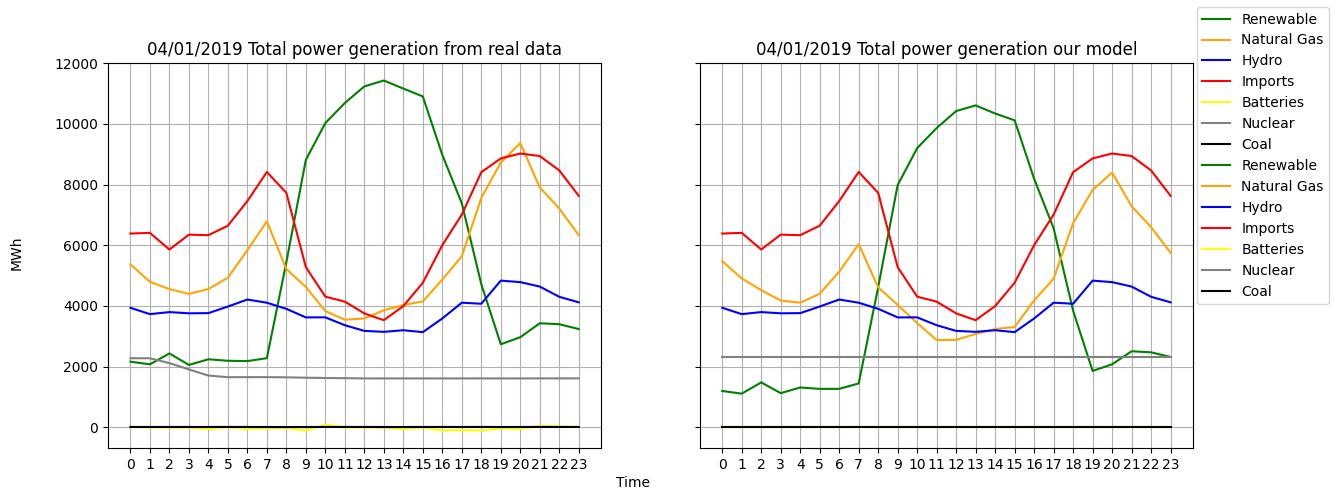

In [60]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(14,5))
x = [i for i in range(0, 24, 1)]
ax1.plot(x, actual_supply[0], label='Renewable', color='green')
ax1.plot(x, actual_supply[1], label='Natural Gas', color='orange')
ax1.plot(x, actual_supply[2], label='Hydro', color='blue')
ax1.plot(x, actual_supply[3], label='Imports', color='red')
ax1.plot(x, actual_supply[4], label='Batteries', color='yellow')
ax1.plot(x, actual_supply[5], label='Nuclear', color='grey')
ax1.plot(x, actual_supply[6], label='Coal', color='black')
fig.text(0.5, 0.04, 'Time', ha='center', va='center')
fig.text(0.06, 0.5, 'MWh', ha='center', va='center', rotation='vertical')
ax1.grid()
ax1.set_xticks([i for i in range(0,24,1)])
ax1.set_title("04/01/2019 Total power generation from real data")
ax2.plot(x, pg_time_by_type_copy[2], label='Renewable', color='green')
ax2.plot(x, pg_time_by_type_copy[1], label='Natural Gas', color='orange')
ax2.plot(x, actual_supply[2], label='Hydro', color='blue')
ax2.plot(x, actual_supply[3], label='Imports', color='red')
ax2.plot(x, pg_time_by_type_copy[6], label='Batteries', color='yellow')
ax2.plot(x, pg_time_by_type_copy[7], label='Nuclear', color='grey')
ax2.plot(x, pg_time_by_type_copy[5], label='Coal', color='black')
ax2.set_xticks([i for i in range(0,24,1)])
ax2.set_title("04/01/2019 Total power generation our model")
fig.legend()
ax2.grid()
#fig.tight_layout()

In [61]:
# co2 estimation linear regression model
target_emissions = []
actual_supply_renew = []
for i in range(10, 32):
    te = pd.read_csv("data/201907/CAISO-co2-per-resource-201907"+str(i)+".csv").to_numpy()[:,1:].T
    asr = pd.read_csv("data/201907/CAISO-supply-201907"+str(i)+".csv").to_numpy()[:,1:].T
    for j in range(0,288):
        if j%12 == 0:
            target_emissions.append(list(te[j,:]))
            actual_supply_renew.append(list(asr[j,:]))
target_emissions = np.array(target_emissions).T
actual_supply_renew = np.array(actual_supply_renew).T

In [62]:
carb_e = []
for i in range(6):
    reg = LinearRegression().fit(np.reshape(actual_supply_renew[i], (528,1)), np.reshape(target_emissions[i], (528,1)))
    carb_e.append(reg.predict(np.reshape(pg_time_by_type[i], (24,1))))
carb_e = np.reshape(np.array(carb_e), (6,24))

In [63]:
te = pd.read_csv("data\CAISO-co2-per-resource-20190401.csv").to_numpy()[:,1:].T
target_emissions = []
for i in range(0,288):
    if i%12 == 0:
        target_emissions.append(list(te[i,:]))
pg_time_by_type = np.array(pg_time_by_type[:6,:])
target_emissions = np.array(target_emissions).T

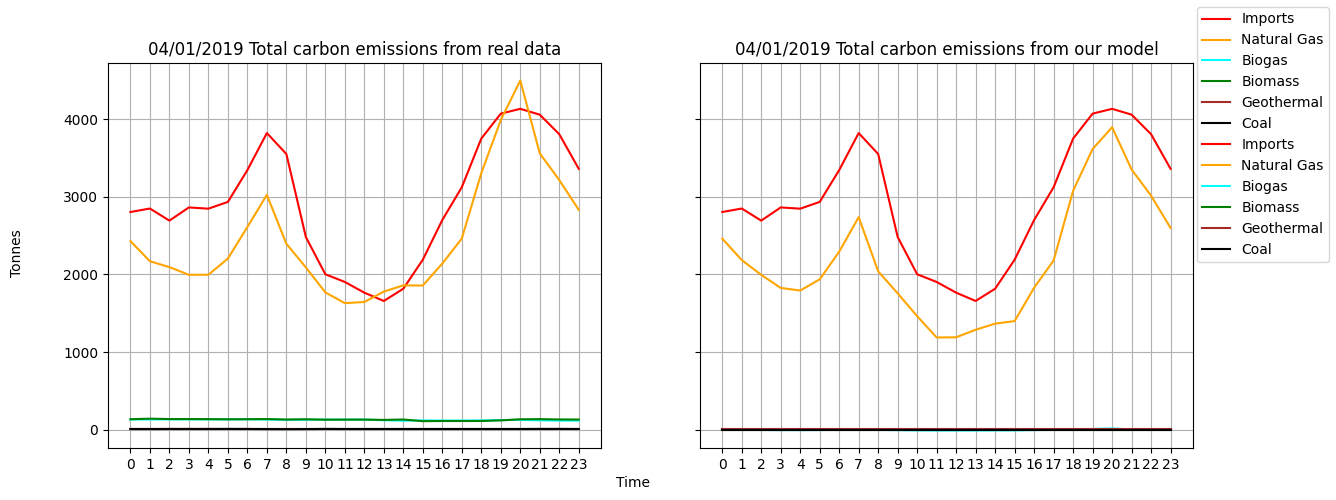

In [64]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(14,5))
#fig.suptitle('Comparison of carbon emissions by fuel type')
x = [i for i in range(0, 24, 1)]
ax1.plot(x, target_emissions[0], label='Imports', color='red')
ax1.plot(x, target_emissions[1], label='Natural Gas', color='orange')
ax1.plot(x, target_emissions[2], label='Biogas', color='cyan')
ax1.plot(x, target_emissions[3], label='Biomass', color='green')
ax1.plot(x, target_emissions[4], label='Geothermal', color='brown')
ax1.plot(x, target_emissions[5], label='Coal', color='black')
ax1.set_xticks([i for i in range(0,24,1)])
ax1.set_title("04/01/2019 Total carbon emissions from real data")
ax1.grid()
ax2.plot(x, target_emissions[0], label='Imports', color='red')
ax2.plot(x, carb_e[1], label='Natural Gas', color='orange')
ax2.plot(x, carb_e[2], label='Biogas', color='cyan')
ax2.plot(x, carb_e[3], label='Biomass', color='green')
ax2.plot(x, carb_e[4], label='Geothermal', color='brown')
ax2.plot(x, carb_e[5], label='Coal', color='black')
fig.text(0.5, 0.04, 'Time', ha='center', va='center')
fig.text(0.06, 0.5, 'Tonnes', ha='center', va='center', rotation='vertical')
ax2.set_xticks([i for i in range(0,24,1)])
ax2.set_title("04/01/2019 Total carbon emissions from our model")
fig.legend()
ax2.grid()
#fig.tight_layout()